In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
import numpy as np



In [6]:
def find_long_zero_periods(
    ts: pd.Series,
    min_duration_days: int,
) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
    """
    Find continuous periods where the time series is zero for at least
    a given number of days.

    Parameters
    ----------
    ts : pd.Series
        Time series with DatetimeIndex.
    min_duration_days : int
        Minimum duration (in days) for a zero-only period.

    Returns
    -------
    list of (pd.Timestamp, pd.Timestamp)
        Start and end timestamps of each detected zero period.
    """
    if min_duration_days <= 0:
        raise ValueError("min_duration_days must be a positive integer")

    min_duration = pd.Timedelta(days=min_duration_days)

    is_zero = ts == 0
    groups = (is_zero != is_zero.shift()).cumsum()

    for _, group in ts[is_zero].groupby(groups):
        start = group.index[0]
        end = group.index[-1]

        # Precise physical duration
        if end - start >= min_duration:
            periods = (start, end)

    return periods


def shrink_timeseries(
    ts: pd.Series,
    shrink_factor: float,
    scale_divisor: float = 1.0,
    preserve_start: str | None = None,
    preserve_end: str | None = None,
) -> pd.Series:
    """
    Shrink or stretch variability of a time series while optionally
    preserving a given time period.

    Parameters
    ----------
    ts : pd.Series
        Time series with DatetimeIndex.
    shrink_factor : float
        Variability scaling factor.
    scale_divisor : float, default 1.0
        Final divisor applied to the whole curve.
    preserve_start : str or None
        Start of period to preserve (inclusive).
    preserve_end : str or None
        End of period to preserve (inclusive).

    Returns
    -------
    pd.Series
        Transformed time series.
    """
    ts = ts.copy()

    if preserve_start is not None and preserve_end is not None:
        preserve_mask = (ts.index >= preserve_start) & (ts.index <= preserve_end)
        shrink_mask = ~preserve_mask
    else:
        shrink_mask = slice(None)

    # Compute mean only on the part that will be modified
    mean_val = ts.loc[shrink_mask].mean()

    ts.loc[shrink_mask] = (
        mean_val
        + shrink_factor * (ts.loc[shrink_mask] - mean_val)
    )

    return ts / scale_divisor


In [7]:
b0=pd.read_csv('B_0.csv', parse_dates=['date'], index_col='date')
b50=pd.read_csv('B_50.csv', parse_dates=['date'], index_col='date')
total_demand = pd.read_csv('Total_demand_hourly.csv', parse_dates=['date'], index_col='date')

In [8]:
day_test = '2023-04-01'

<Axes: xlabel='date'>

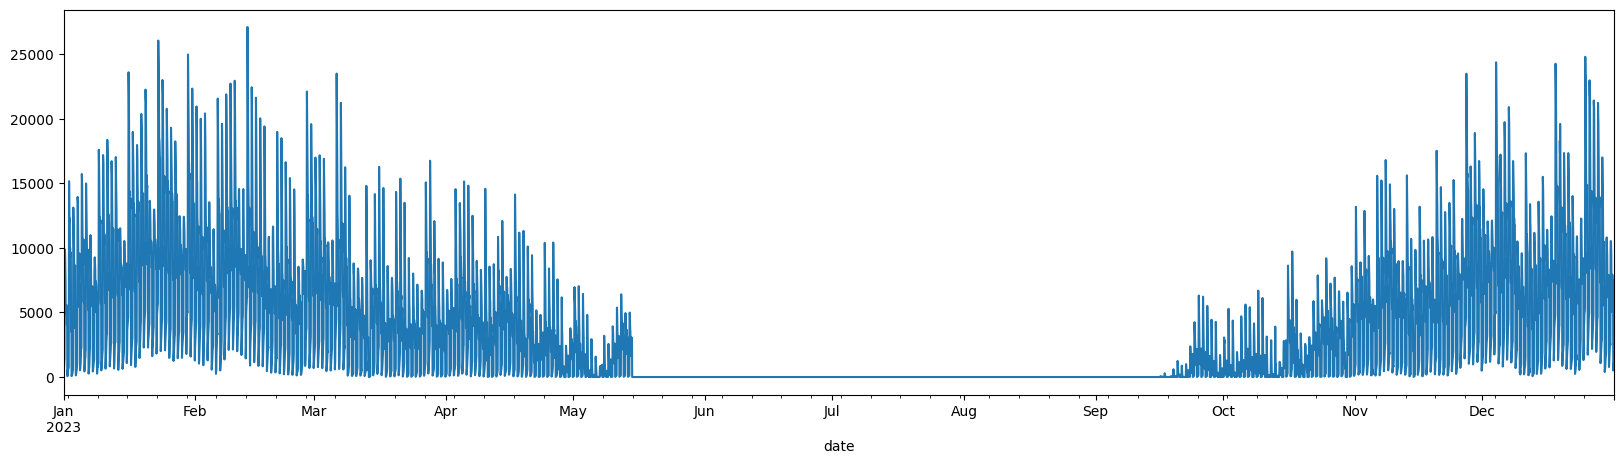

In [9]:
# heating curve
total_demand.Qhs_kWh.plot(figsize=(20,5))

<Axes: xlabel='date'>

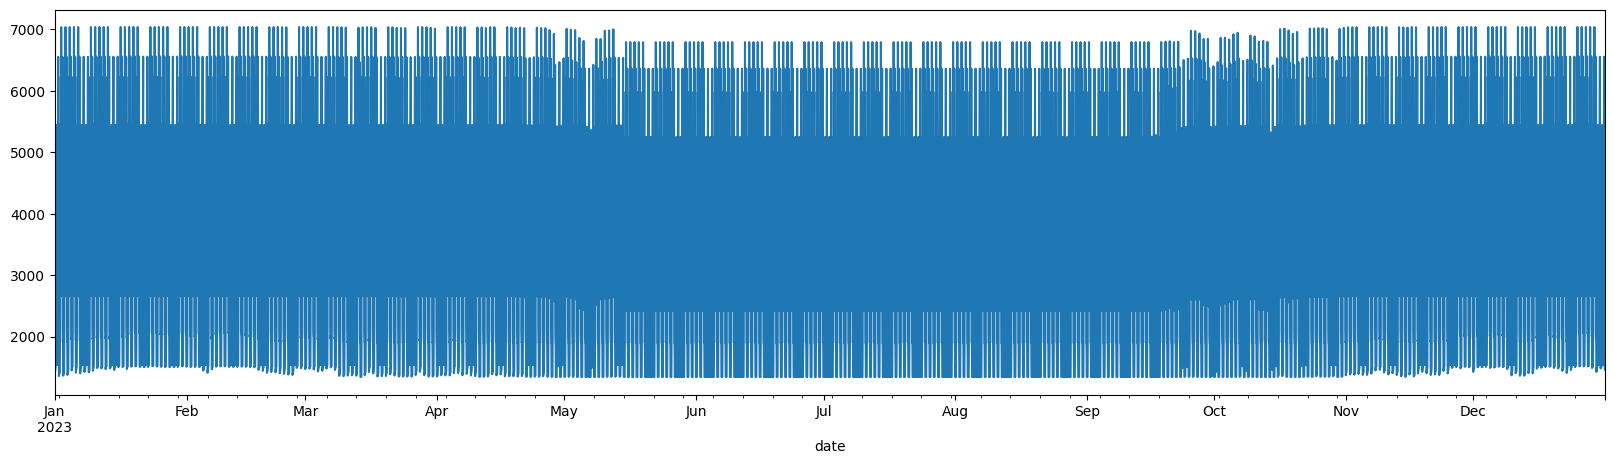

In [10]:
#base curve
total_demand.GRID_kWh.plot(figsize=(20,5))

In [11]:
#real curve (mesured)
f29 = pd.read_csv('f29_2023.csv', parse_dates=['date'], index_col='date')

<Axes: xlabel='date'>

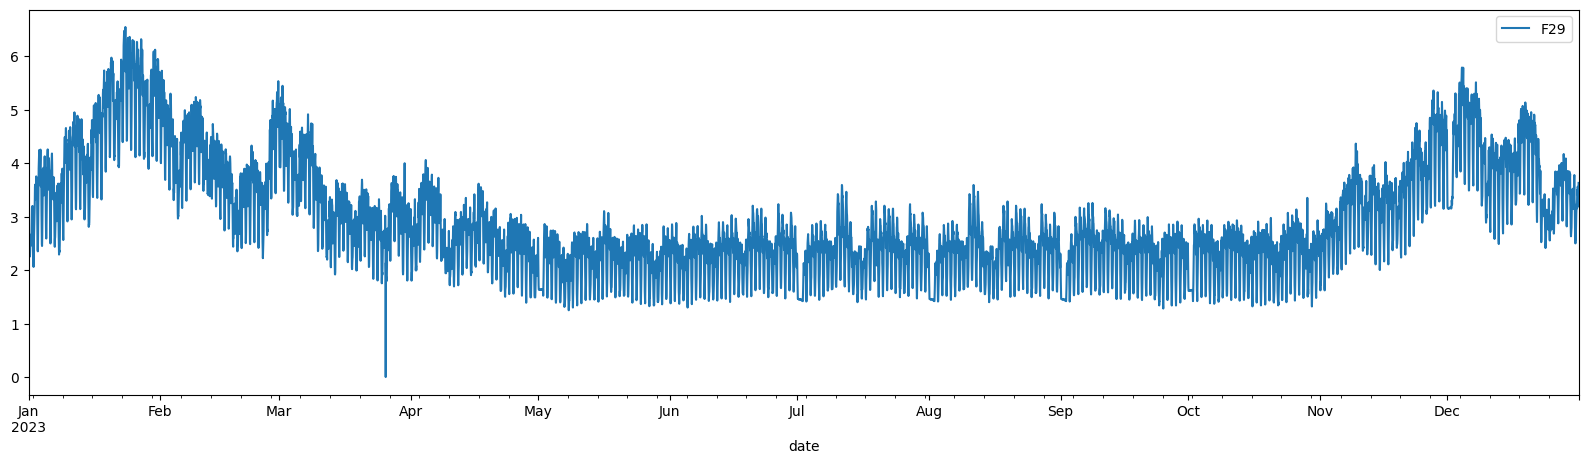

In [12]:
f29_mwh = (f29/6).resample("1h").sum()
f29_mwh.plot(figsize=(20,5))

<Axes: xlabel='date'>

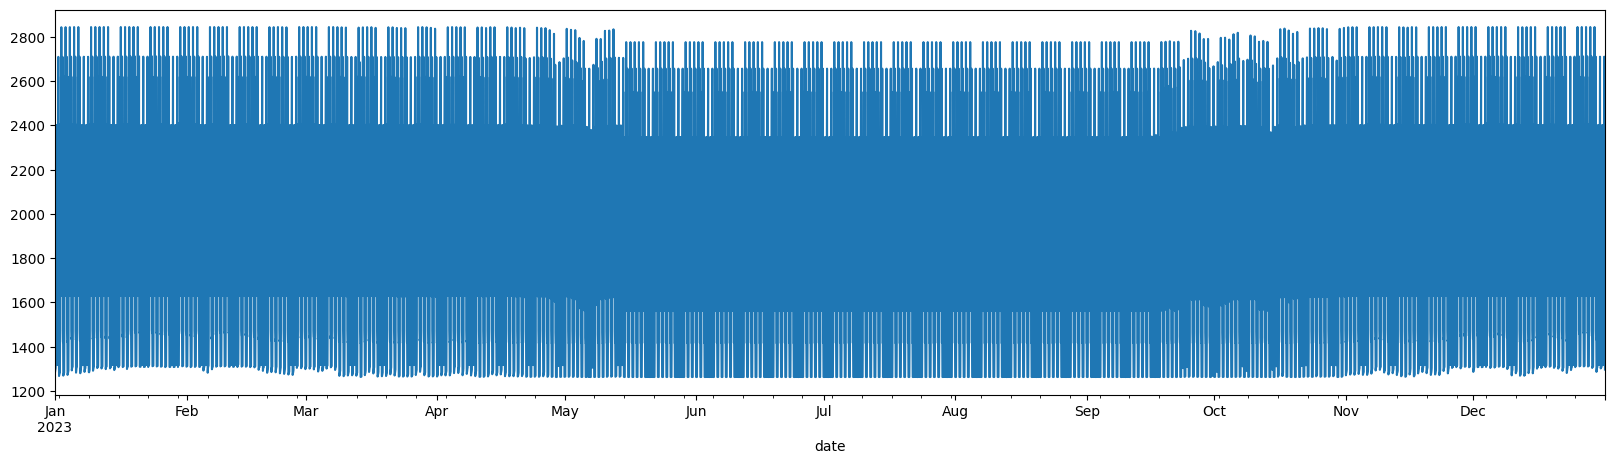

In [13]:
base = shrink_timeseries(total_demand.GRID_kWh, 0.5, 1.8) #  0.5, 1.8 are values that I selected manually to make it look better
base.plot(figsize=(20,5))

with 0.5 and 1.8 the curve seems to fit much better.

<Axes: xlabel='date'>

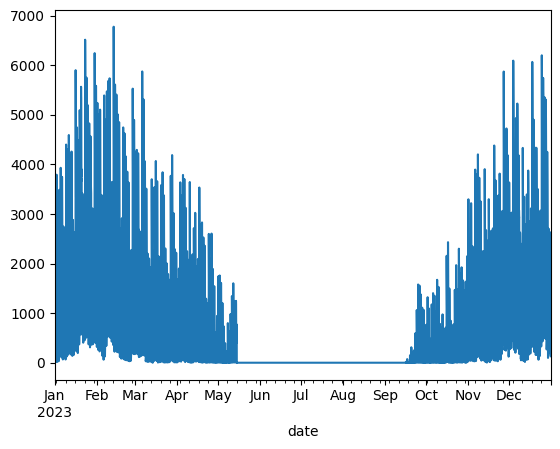

In [14]:

# heating curve
heating = total_demand.Qhs_kWh*0.25  # here I am assuming that 27% of the total heating demand is electrical, you should compute building by building using the heating_energy
heating.plot()

<Axes: xlabel='date'>

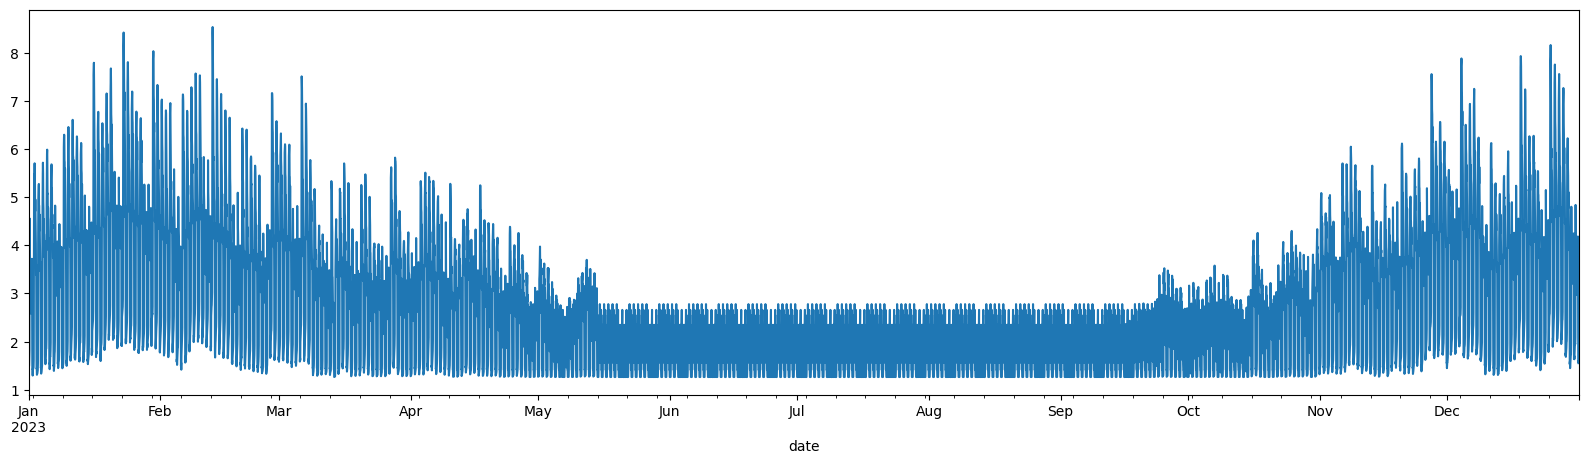

In [15]:
simulated_demand = (base + heating)/1000 #convert to mwh to compare
simulated_demand.plot(figsize=(20,5))

<Axes: xlabel='date'>

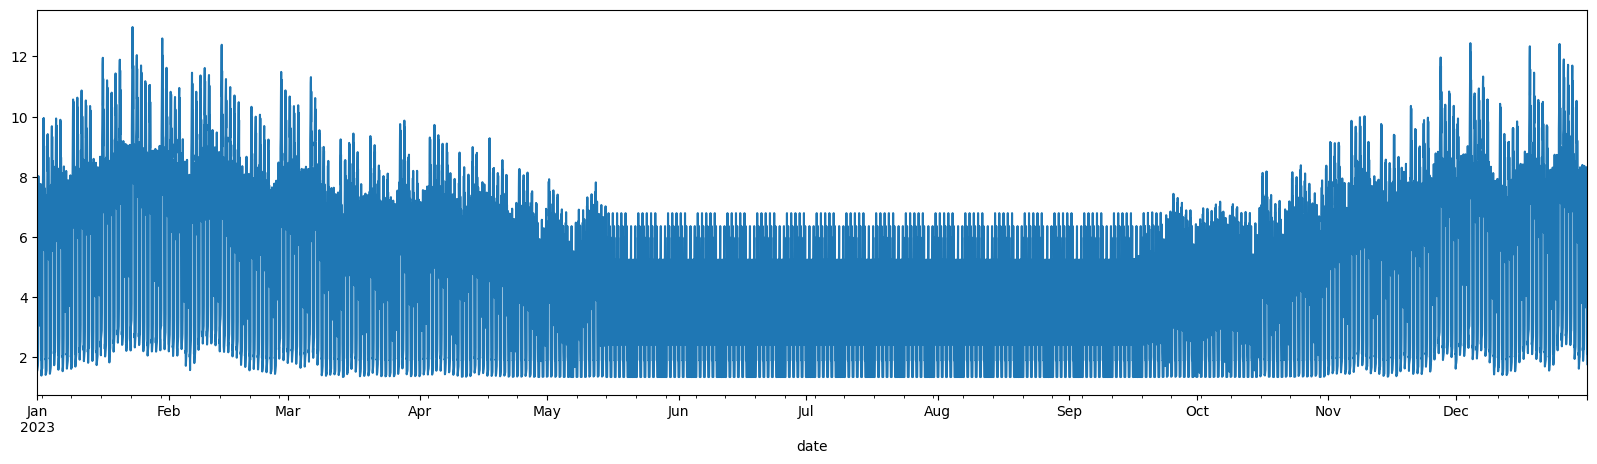

In [23]:
simulated_demand = (total_demand.GRID_kWh + heating)/1000 #convert to mwh to compare
simulated_demand.plot(figsize=(20,5))

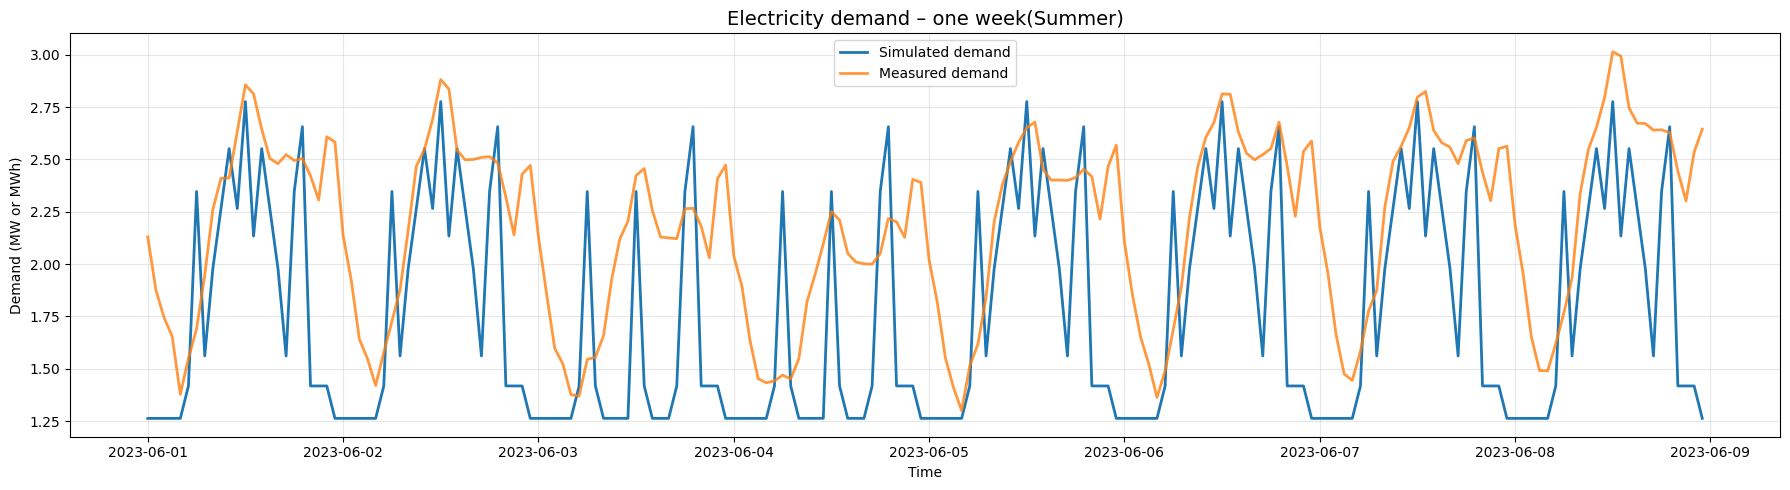

In [16]:
day_test = '2023-06-01'
week_end = '2023-06-08'

sim_week = simulated_demand.loc[day_test:week_end]
real_week = f29_mwh.F29.loc[day_test:week_end]


plt.figure(figsize=(18, 5))

plt.plot(sim_week, label='Simulated demand', linewidth=2)
plt.plot(real_week, label='Measured demand', linewidth=2, alpha=0.8)

plt.title('Electricity demand – one week(Summer)', fontsize=14)
plt.ylabel('Demand (MW or MWh)')
plt.xlabel('Time')

plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Summer is fitting better(peaks and thoughs are matching for this week), but the shape is bad, maybe missing cooling!

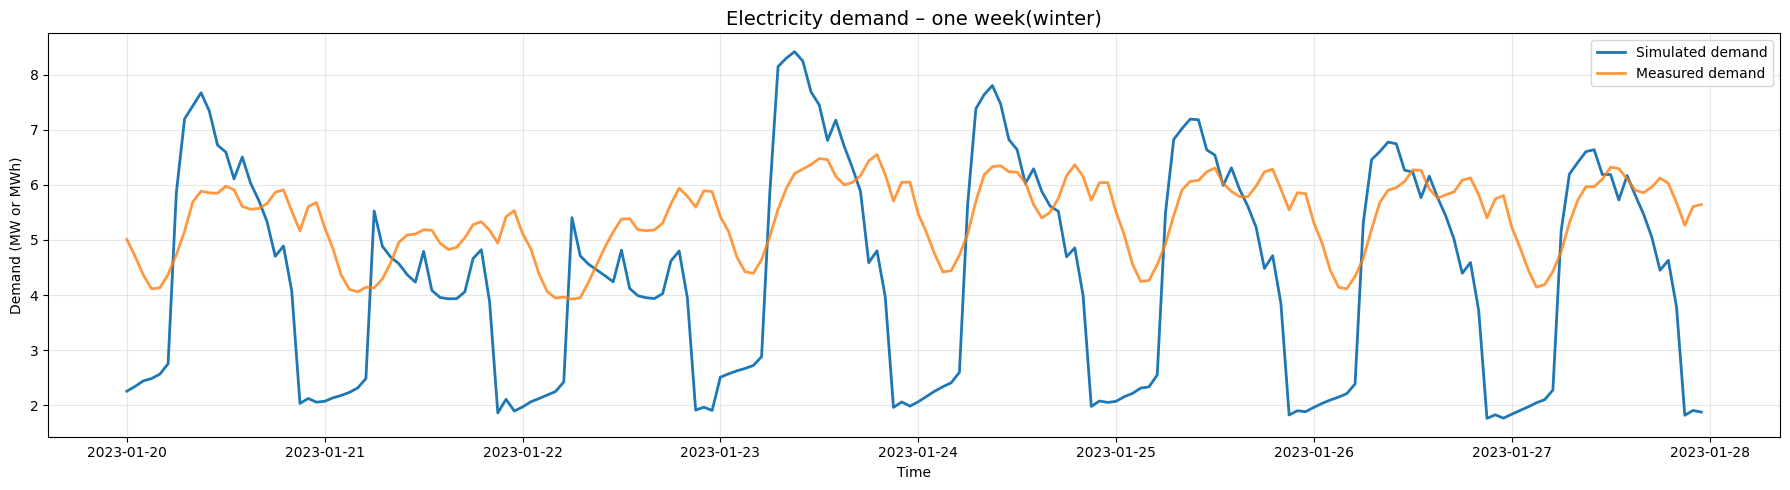

In [17]:
day_test = '2023-01-20'
week_end = '2023-01-27'

sim_week = simulated_demand.loc[day_test:week_end]
real_week = f29_mwh.F29.loc[day_test:week_end]


plt.figure(figsize=(18, 5))

plt.plot(sim_week, label='Simulated demand', linewidth=2)
plt.plot(real_week, label='Measured demand', linewidth=2, alpha=0.8)

plt.title('Electricity demand – one week(winter)', fontsize=14)
plt.ylabel('Demand (MW or MWh)')
plt.xlabel('Time')

plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The shape of the curve looks better in the winter, but still not well fitted(about 2MWh of difference for this week)!

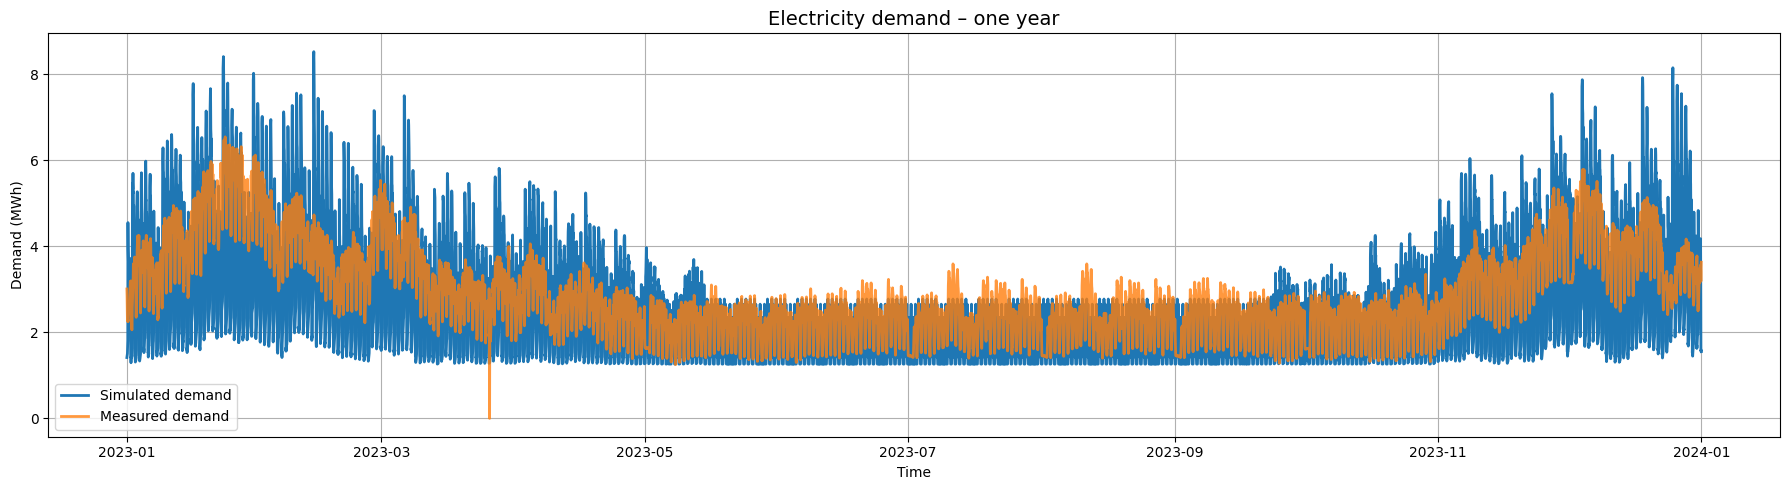

In [18]:
sim_year = simulated_demand
real_year = f29_mwh.F29


plt.figure(figsize=(18, 5))

plt.plot(sim_year, label='Simulated demand', linewidth=2)
plt.plot(real_year, label='Measured demand', linewidth=2, alpha=0.8)

plt.title('Electricity demand – one year', fontsize=14)
plt.ylabel('Demand (MWh)')
plt.xlabel('Time')

plt.legend()
plt.grid(True, alpha=1)

plt.tight_layout()
plt.show()


In [19]:
# CV metrics
mae = mean_absolute_error(f29_mwh.F29, simulated_demand)
mse = mean_squared_error(f29_mwh.F29, simulated_demand)
rmse = np.sqrt(mse)
r2 = r2_score(f29_mwh.F29, simulated_demand)

# MAPE (exclude zero true values)
mask = f29_mwh.F29 != 0
# mape = np.mean(np.abs((f29_mwh.F29[mask] - simulated_demand[mask]) / f29_mwh.F29[mask])) * 100

print('MWh')
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
# print(f"R²: {r2}")
# print(f"MAPE (f29_mwh.F29 != 0): {mape:.2f}%")


MWh
Mean Absolute Error (MAE): 0.90178920426412
Mean Squared Error (MSE): 1.346453453986005
Root Mean Squared Error (RMSE): 1.1603678097853305


# Second approach: shrink_timeseries in the entire curve at once

In [20]:
simulated_demand = (total_demand.GRID_kWh + heating)/1000

sim_year = simulated_demand
real_year = f29_mwh.F29


plt.figure(figsize=(18, 5))z

plt.plot(sim_year, label='Simulated demand', linewidth=2)
plt.plot(real_year, label='Measured demand', linewidth=2, alpha=0.8)

plt.title('Electricity demand – one year', fontsize=14)
plt.ylabel('Demand (MWh)')
plt.xlabel('Time')

plt.legend()
plt.grid(True, alpha=1)

plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (3530172553.py, line 7)

This is the original, without shrink, assuming 25% of heating

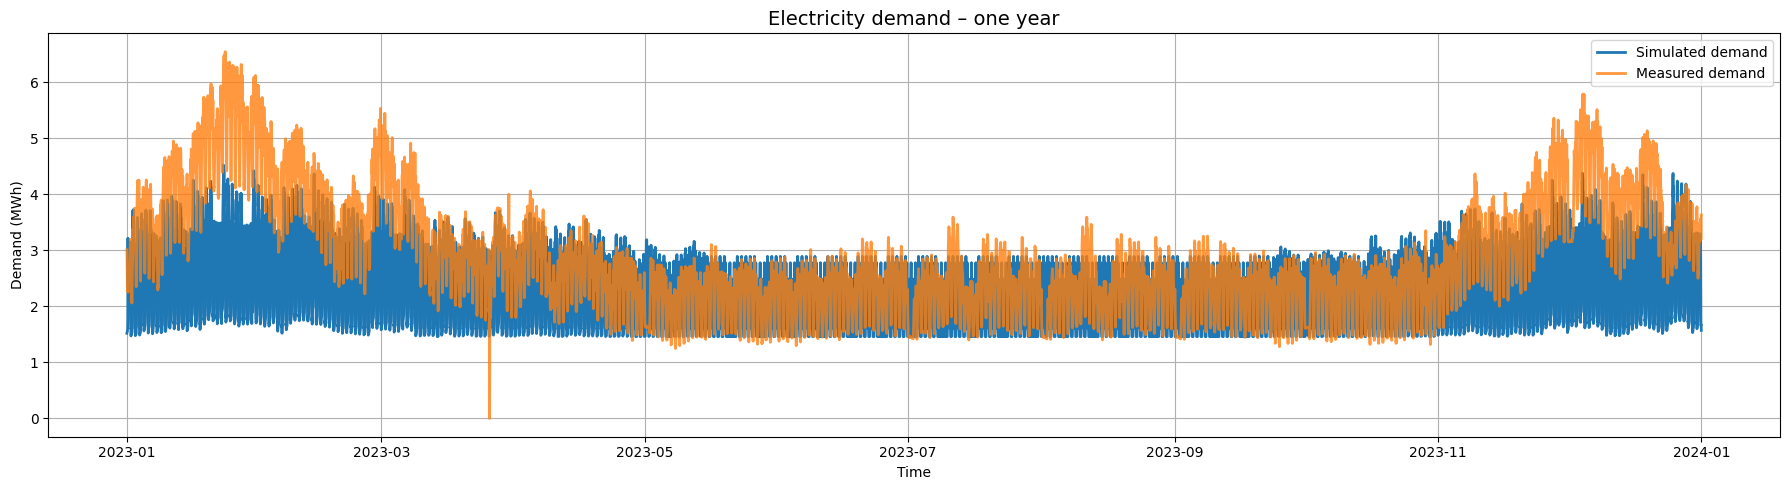

In [22]:
heating = total_demand.Qhs_kWh*0.30

simulated_demand = (total_demand.GRID_kWh + heating)/1000
simulated_demand = shrink_timeseries(simulated_demand, 0.5, 1.9)

sim_year = simulated_demand
real_year = f29_mwh.F29


plt.figure(figsize=(18, 5))

plt.plot(sim_year, label='Simulated demand', linewidth=2)
plt.plot(real_year, label='Measured demand', linewidth=2, alpha=0.8)

plt.title('Electricity demand – one year', fontsize=14)
plt.ylabel('Demand (MWh)')
plt.xlabel('Time')

plt.legend()
plt.grid(True, alpha=1)

plt.tight_layout()
plt.show()


In [ ]:
# metrics
mae = mean_absolute_error(f29_mwh, simulated_demand)
mse = mean_squared_error(f29_mwh, simulated_demand)
rmse = np.sqrt(mse)
r2 = r2_score(f29_mwh, simulated_demand)

# MAPE (exclude zero true values)
mask = f29_mwh != 0
# mape = np.mean(np.abs((f29_mwh[mask] - simulated_demand[mask]) / f29_mwh[mask])) * 100

print('MWh')
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
# print(f"R²: {r2}")
# print(f"MAPE (f29_mwh != 0): {mape:.2f}%")


MWh
Mean Absolute Error (MAE): 0.857101264358488
Mean Squared Error (MSE): 1.3197430029629407
Root Mean Squared Error (RMSE): 1.1488006802587387


Now you can re-run the week analysis

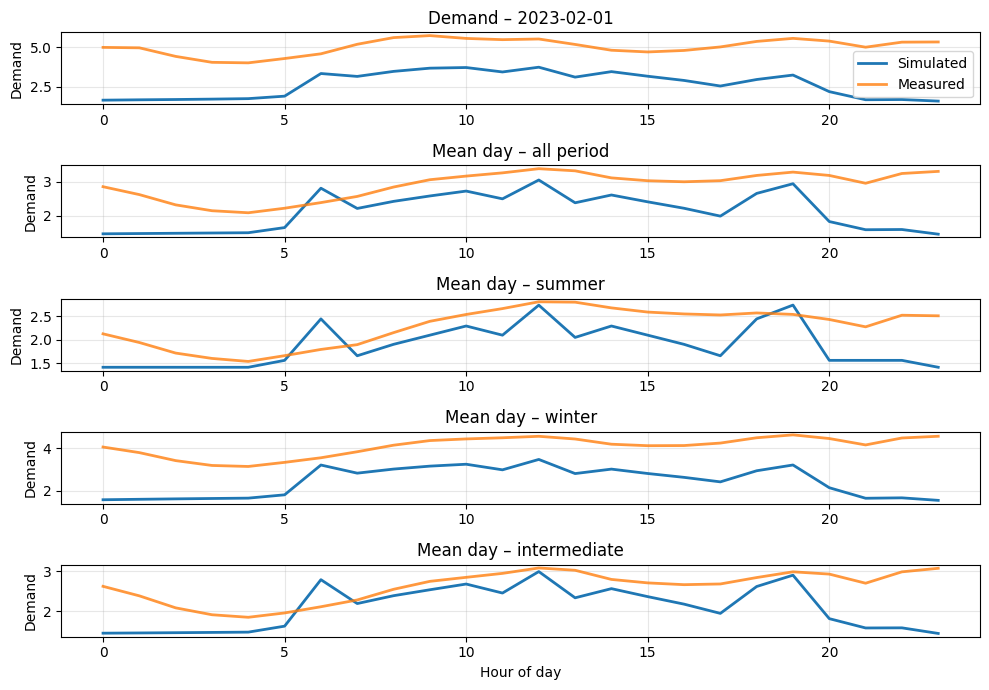

In [ ]:

def mean_day(series):
    """
    Returns mean daily profile (0–23h)
    """
    df = series.copy()
    df = df.to_frame('value')
    df['hour'] = df.index.hour
    return df.groupby('hour')['value'].mean()
summer_months = [6, 7, 8]
winter_months = [12, 1, 2]
intermediate_months = [3, 4, 5, 9, 10, 11]
sim = simulated_demand
real = f29_mwh.F29
day = '2023-02-01'

sim_day = sim.loc[day]
real_day = real.loc[day]

sim_mean_all = mean_day(sim)
real_mean_all = mean_day(real)

sim_summer = mean_day(sim[sim.index.month.isin(summer_months)])
real_summer = mean_day(real[real.index.month.isin(summer_months)])

sim_winter = mean_day(sim[sim.index.month.isin(winter_months)])
real_winter = mean_day(real[real.index.month.isin(winter_months)])

sim_inter = mean_day(sim[sim.index.month.isin(intermediate_months)])
real_inter = mean_day(real[real.index.month.isin(intermediate_months)])


fig, axs = plt.subplots(5, 1, figsize=(10, 7), sharex=False)

# --- 1. Specific day ---
axs[0].plot(sim_day.index.hour, sim_day.values, label='Simulated', linewidth=2)
axs[0].plot(real_day.index.hour, real_day.values, label='Measured', linewidth=2, alpha=0.8)
axs[0].set_title(f'Demand – {day}')
axs[0].set_ylabel('Demand')
axs[0].legend()
axs[0].grid(alpha=0.3)

# --- 2. Mean day (all) ---
axs[1].plot(sim_mean_all.index, sim_mean_all.values, linewidth=2)
axs[1].plot(real_mean_all.index, real_mean_all.values, linewidth=2, alpha=0.8)
axs[1].set_title('Mean day – all period')
axs[1].set_ylabel('Demand')
axs[1].grid(alpha=0.3)

# --- 3. Summer ---
axs[2].plot(sim_summer.index, sim_summer.values, linewidth=2)
axs[2].plot(real_summer.index, real_summer.values, linewidth=2, alpha=0.8)
axs[2].set_title('Mean day – summer')
axs[2].set_ylabel('Demand')
axs[2].grid(alpha=0.3)

# --- 4. Winter ---
axs[3].plot(sim_winter.index, sim_winter.values, linewidth=2)
axs[3].plot(real_winter.index, real_winter.values, linewidth=2, alpha=0.8)
axs[3].set_title('Mean day – winter')
axs[3].set_ylabel('Demand')
axs[3].grid(alpha=0.3)

# --- 5. Intermediate ---
axs[4].plot(sim_inter.index, sim_inter.values, linewidth=2)
axs[4].plot(real_inter.index, real_inter.values, linewidth=2, alpha=0.8)
axs[4].set_title('Mean day – intermediate')
axs[4].set_ylabel('Demand')
axs[4].set_xlabel('Hour of day')
axs[4].grid(alpha=0.3)

plt.tight_layout()
plt.show()

